### Import Lybraries

In [9]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from nltk import tokenize

import itertools
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [10]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost, textblob, string

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies
from yellowbrick.classifier import ClassificationReport
from yellowbrick.text import PosTagVisualizer

In [11]:
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

### Folders to csv

In [7]:
base_folder = "bbc"
folders = ["business","entertainment","politics","sport","tech"]

#os.chdir(base_folder)

x = []
y = []

for i in folders:
    path = base_folder+"/"+i
    files = os.listdir(path)
    print("reading folder: {}".format(i.strip().split('\\')[-1]))
    for text_file in files:
        file_path = path + "/" +text_file
        with open(file_path) as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(path)
   
data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
print('writing csv flie ...')
df.to_csv('../bbc_dataset.csv', index=False)


reading folder: business
reading folder: entertainment
reading folder: politics
reading folder: sport
reading folder: tech
writing csv flie ...


### Useful Functions

In [8]:
def clean_str(string):
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [9]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [40]:
def pos_tag_viz():
    tagged_stanzas = [
        [
            [
                ('Whose', 'JJ'),('woods', 'NNS'),('these', 'DT'),
                ('are', 'VBP'),('I', 'PRP'),('think', 'VBP'),('I', 'PRP'),
                ('know', 'VBP'),('.', '.')
                ],
            [
                ('His', 'PRP$'),('house', 'NN'),('is', 'VBZ'),('in', 'IN'),
                ('the', 'DT'),('village', 'NN'),('though', 'IN'),(';', ':'),
                ('He', 'PRP'),('will', 'MD'),('not', 'RB'),('see', 'VB'),
                ('me', 'PRP'),('stopping', 'VBG'), ('here', 'RB'),('To', 'TO'),
                ('watch', 'VB'),('his', 'PRP$'),('woods', 'NNS'),('fill', 'VB'),
                ('up', 'RP'),('with', 'IN'),('snow', 'NNS'),('.', '.')
                ]
            ],
        [
            [
                ('My', 'PRP$'),('little', 'JJ'),('horse', 'NN'),('must', 'MD'),
                ('think', 'VB'),('it', 'PRP'),('queer', 'JJR'),('To', 'TO'),
                ('stop', 'VB'),('without', 'IN'),('a', 'DT'),('farmhouse', 'NN'),
                ('near', 'IN'),('Between', 'NNP'),('the', 'DT'),('woods', 'NNS'),
                ('and', 'CC'),('frozen', 'JJ'),('lake', 'VB'),('The', 'DT'),
                ('darkest', 'JJS'),('evening', 'NN'),('of', 'IN'),('the', 'DT'),
                ('year', 'NN'),('.', '.')
                ]
            ],
        [
            [
                ('He', 'PRP'),('gives', 'VBZ'),('his', 'PRP$'),('harness', 'NN'),
                ('bells', 'VBZ'),('a', 'DT'),('shake', 'NN'),('To', 'TO'),
                ('ask', 'VB'),('if', 'IN'),('there', 'EX'),('is', 'VBZ'),
                ('some', 'DT'),('mistake', 'NN'),('.', '.')
                ],
            [
                ('The', 'DT'),('only', 'JJ'),('other', 'JJ'),('sound', 'NN'),
                ('’', 'NNP'),('s', 'VBZ'),('the', 'DT'),('sweep', 'NN'),
                ('Of', 'IN'),('easy', 'JJ'),('wind', 'NN'),('and', 'CC'),
                ('downy', 'JJ'),('flake', 'NN'),('.', '.')
                ]
            ],
        [
            [
                ('The', 'DT'),('woods', 'NNS'),('are', 'VBP'),('lovely', 'RB'),
                (',', ','),('dark', 'JJ'),('and', 'CC'),('deep', 'JJ'),(',', ','),
                ('But', 'CC'),('I', 'PRP'),('have', 'VBP'),('promises', 'NNS'),
                ('to', 'TO'),('keep', 'VB'),(',', ','),('And', 'CC'),('miles', 'NNS'),
                ('to', 'TO'),('go', 'VB'),('before', 'IN'),('I', 'PRP'),
                ('sleep', 'VBP'),(',', ','),('And', 'CC'),('miles', 'NNS'),
                ('to', 'TO'),('go', 'VB'),('before', 'IN'),('I', 'PRP'),
                ('sleep', 'VBP'),('.', '.')
                ]
        ]
    ]
    
    return tagged_stanzas

### Data Visualization

In [16]:
df = pd.read_csv("bbc_dataset.csv")
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,news,type
0,Franz Ferdinand's art school lesson\n \n Scott...,entertainment
1,Hewitt falls to Dent in Adelaide\n \n Lleyton ...,sport
2,Bafta to hand out movie honours\n \n Movie sta...,entertainment
3,Robinson ready for difficult task\n \n England...,sport
4,'Hitler' row over Welsh arts cash\n \n An arti...,politics


In [52]:
## Unique classes
df['type'].unique()

array(['politics', 'tech', 'entertainment', 'sport', 'business'],
      dtype=object)

In [53]:
## Total instances
print("total samples: {}\ntotal features: {}".format(df.shape[0],df.shape[1]))

total samples: 2225
total features: 2


In [54]:
## counts related to different classes
df['type'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: type, dtype: int64

#### Count Plot for all types

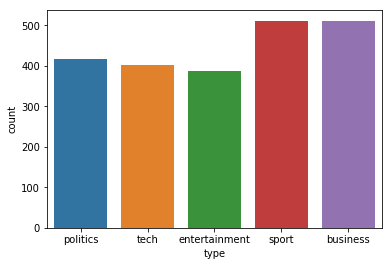

In [55]:
sns.countplot(df['type'])

#### Pos Tag Visualization

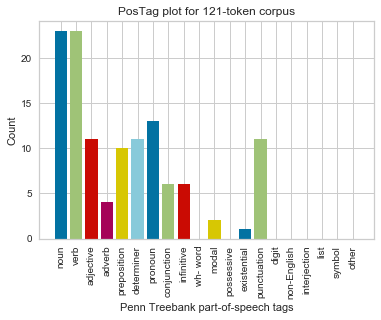

In [43]:
tag_st = pos_tag_viz()
viz = PosTagVisualizer()
viz.fit(tag_st)
viz.poof()

#### Pie Chart

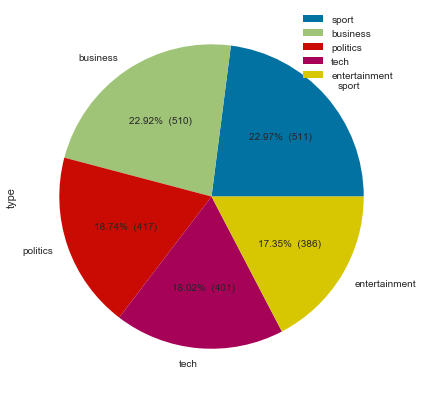

In [57]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val=int((pct*total/100.0)+0.5)
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
types = df['type'].value_counts()
types.plot(kind='pie', legend=True, figsize=(7,7), autopct=make_autopct(types));

#### Highly Correlated Words

In [70]:
df['category_id'] = df['type'].factorize()[0]
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df['news']).toarray()
labels = df.category_id 

N = 5  # We are going to look for top 5 categories
#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 5 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 5 bigrams with highest Chi squared stat


# 'business':
  . Most correlated unigrams:
       . economy
       . bank
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . chief executive
       . oil prices
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . album
       . awards
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . best film
       . million dollar
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . tory
       . party
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . mr brown
       . general election
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . season
       . injury
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . world cup
       . year old
       . grand slam
       . austral

#### Distribution plots

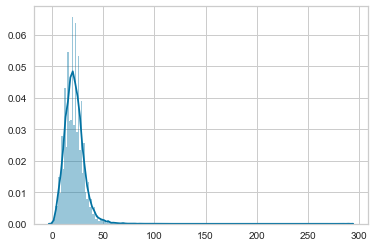

In [84]:
def simple_clean(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()
paras, labels, texts, sent_lens, sent_nums = [],[],[],[],[]
for idx in range(df.news.shape[0]):
    text = simple_clean(df.news[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)
sns.distplot(sent_lens, bins=200)
plt.show()

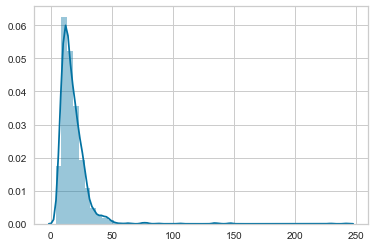

In [85]:
sns.distplot(sent_nums)
plt.show()

### Data Preprocessing

In [56]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

data = pd.read_csv('bbc_dataset.csv')
x = data['news'].tolist()
y = data['type'].tolist()

print("processing the data...")
for index,value in enumerate(x):
    #print("processing data:",index)
    x[index] = ' '.join([Word(word).lemmatize() for word in clean_str(value).split()])

vect = TfidfVectorizer(stop_words='english',min_df=2)
X = vect.fit_transform(x)
Y = np.array(y)

print("no of features extracted:",X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("train size:", X_train.shape)
print("test size:", X_test.shape)


processing the data...
no of features extracted: 14788
train size: (1780, 14788)
test size: (445, 14788)


In [57]:
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

Train size: 1780
Test size: 445


In [58]:
train_cat, test_cat = train_test_split(df['type'], train_size)
train_text, test_text = train_test_split(df['news'], train_size)
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)
tokenize.fit_on_texts(train_text) # fit tokenizer to our training text data
nn_x_train = tokenize.texts_to_matrix(train_text)
nn_x_test = tokenize.texts_to_matrix(test_text)
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_cat)
nn_y_train = encoder.transform(train_cat)
nn_y_test = encoder.transform(test_cat)
# Converts the labels to a one-hot representation
num_classes = np.max(nn_y_train) + 1
nn_y_train = keras.utils.to_categorical(nn_y_train, num_classes)
nn_y_test = keras.utils.to_categorical(nn_y_test, num_classes)
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', nn_x_train.shape)
print('x_test shape:', nn_x_test.shape)
print('y_train shape:', nn_y_train.shape)
print('y_test shape:', nn_y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape: (1780, 5)
y_test shape: (445, 5)


### Data Distribution Visualization

In [11]:
## splittig the original data to explore the distribution
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['news'], df['type'])

train_labels = train_y
valid_labels = valid_y
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

#### TSNE Plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

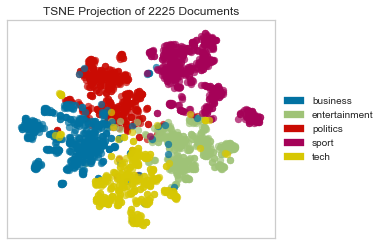

In [47]:
# Load the data and create document vectors
corpus = load_hobbies()
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(df['news'])
y = df['type']

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.poof()

#### Counting Vectors as features

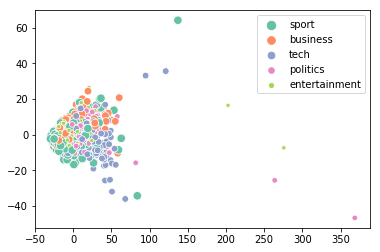

In [14]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['news'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
# plot the train features
pca = PCA(n_components=2).fit(xtrain_count.toarray())
data2D = pca.transform(xtrain_count.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="Set2")

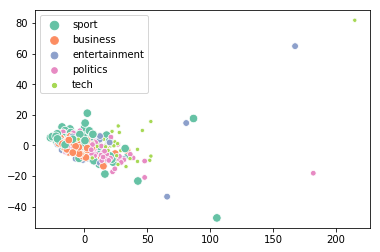

In [16]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_count.toarray())
data2D = pca.transform(xvalid_count.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="Set2")

#### TF-IDF Vectors

#### -> word level tf-idf

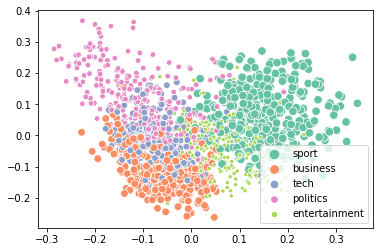

In [20]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['news'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# plot the train features
pca = PCA(n_components=2).fit(xtrain_tfidf.toarray())
data2D = pca.transform(xtrain_tfidf.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="Set2")

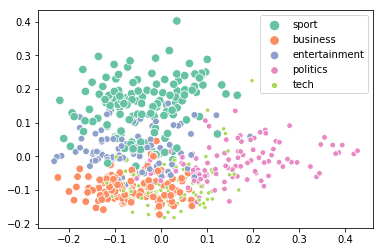

In [21]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_tfidf.toarray())
data2D = pca.transform(xvalid_tfidf.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="Set2")

#### ngram level tf-idf

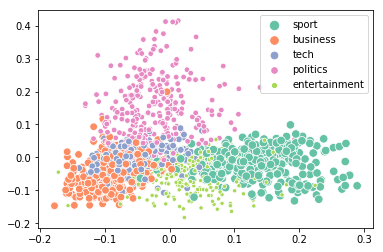

In [23]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['news'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# plot the train features
pca = PCA(n_components=2).fit(xtrain_tfidf_ngram.toarray())
data2D = pca.transform(xtrain_tfidf_ngram.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="Set2")

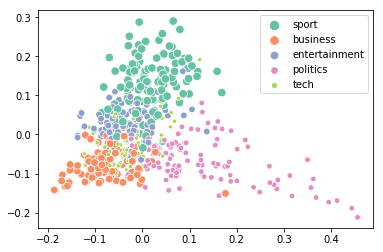

In [24]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_tfidf_ngram.toarray())
data2D = pca.transform(xvalid_tfidf_ngram.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="Set2")

#### characters level tf-idf

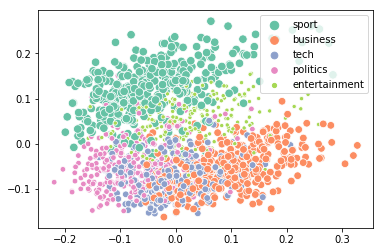

In [27]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['news'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

# plot the train features
pca = PCA(n_components=2).fit(xtrain_tfidf_ngram_chars.toarray())
data2D = pca.transform(xtrain_tfidf_ngram_chars.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="Set2")

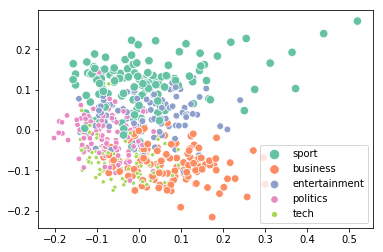

In [28]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_tfidf_ngram_chars.toarray())
data2D = pca.transform(xvalid_tfidf_ngram_chars.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="Set2")

#### HashingVectorizer

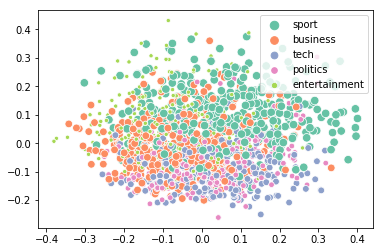

In [29]:
# getting train features
hash_vectorizer = HashingVectorizer(n_features=5000)
hash_vectorizer.fit(df['news'])
xtrain_hash_vectorizer =  hash_vectorizer.transform(train_x) 
xvalid_hash_vectorizer =  hash_vectorizer.transform(valid_x)

# plot the train features
pca = PCA(n_components=2).fit(xtrain_hash_vectorizer.toarray())
data2D = pca.transform(xtrain_hash_vectorizer.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=train_labels.tolist(),size=train_labels.tolist(),palette="Set2")

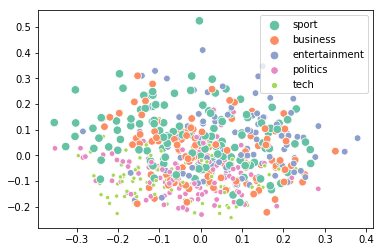

In [30]:
# plot the validation features
pca = PCA(n_components=2).fit(xvalid_hash_vectorizer.toarray())
data2D = pca.transform(xvalid_hash_vectorizer.toarray())
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=valid_labels.tolist(),size=valid_labels.tolist(),palette="Set2")

### Model Training

### 1) With machineLearning algorithms

In [41]:
def ml_model_pipeline(ml_model):
    # Algorithm on Count Vectors
    accuracy = train_model(ml_model, xtrain_count, train_y, xvalid_count)
    print("Count Vectors: ", accuracy)

    # Algorithm on Word Level TF IDF Vectors
    accuracy = train_model(ml_model, xtrain_tfidf, train_y, xvalid_tfidf)
    print("WordLevel TF-IDF: ", accuracy)

    # Algorithm on Ngram Level TF IDF Vectors
    accuracy = train_model(ml_model, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
    print("N-Gram Vectors: ", accuracy)

    # Algorithm on Character Level TF IDF Vectors
    accuracy = train_model(ml_model, xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
    print("CharLevel Vectors: ", accuracy)

In [45]:
m_pipe = [["Naive Bayes",naive_bayes.MultinomialNB()],["Logistic Regression",linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000)],["Random Forest",ensemble.RandomForestClassifier(n_estimators=10)],["XGBoost",xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc()]]

for l1 in m_pipe:
    print("\n====================\t<<< {} >>>\t=======================".format(l1[0]))
    ml_model_pipeline(l1[1])
print("===========================================")


====================	<<< Naive Bayes >>>	=======================
Count Vectors:  0.9748653500897666
WordLevel TF-IDF:  0.9730700179533214
N-Gram Vectors:  0.9228007181328546
CharLevel Vectors:  0.8994614003590664

====================	<<< Logistic Regression >>>	=======================
Count Vectors:  0.9694793536804309
WordLevel TF-IDF:  0.9802513464991023
N-Gram Vectors:  0.940754039497307
CharLevel Vectors:  0.9515260323159784

====================	<<< Random Forest >>>	=======================
Count Vectors:  0.8725314183123878
WordLevel TF-IDF:  0.9012567324955116
N-Gram Vectors:  0.7935368043087971
CharLevel Vectors:  0.8330341113105925

====================	<<< XGBoost >>>	=======================
Count Vectors:  0.9551166965888689
WordLevel TF-IDF:  0.9497307001795332
N-Gram Vectors:  0.8707360861759426
CharLevel Vectors:  0.9551166965888689


In [46]:
## observations: charLevel Vectors method is taking more time to calculate results.

### 2) with Neural Networks 

In [78]:
from keras.models import Sequential
from keras.layers import Dense,Activation

batch_size = 32
epochs = 10
drop_ratio = 0.5
max_words = 1000
num_classes = 5

In [79]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
# model.add(layers.Dropout(drop_ratio))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [80]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min')
mcp_save = ModelCheckpoint('saved_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

In [81]:
history = model.fit(nn_x_train, nn_y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Train on 1602 samples, validate on 178 samples
Epoch 1/10
1602/1602 [==============================] - 3s 2ms/step - loss: 0.4258 - acc: 0.8889 - val_loss: 0.1839 - val_acc: 0.9438
Epoch 2/10
1602/1602 [==============================] - 2s 1ms/step - loss: 0.0389 - acc: 0.9931 - val_loss: 0.1743 - val_acc: 0.9551
Epoch 3/10
1602/1602 [==============================] - 2s 1ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.1718 - val_acc: 0.9607
Epoch 4/10
1602/1602 [==============================] - 2s 1ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1727 - val_acc: 0.9607
Epoch 5/10
1602/1602 [==============================] - 2s 975us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.1760 - val_acc: 0.9551

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
1602/1602 [==============================] - 1s 719us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1752 - val_acc: 0.9551
Epoch 7/10
1602/1602 [==============================] - 1s 625u

In [82]:
# Evaluate the accuracy of our trained model
score = model.evaluate(nn_x_test, nn_y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

445/445 [==============================] - 0s 233us/step
Test loss: 0.11695640237813586
Test accuracy: 0.9685393246372095


#### Some predictions

In [83]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([nn_x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print("Text: {} ...".format(clean_str(test_text.iloc[i][:50])))
    print('Actual label:\t' + test_cat.iloc[i])
    print("Pred label:\t" + predicted_label + "\n")  

Text: air passengers win new eu rights air passengers ...
Actual label:	business
Pred label:	business

Text: ireland v usa sat saturday november lan ...
Actual label:	sport
Pred label:	sport

Text: van gogh festival film withdrawn murdered direc ...
Actual label:	entertainment
Pred label:	entertainment

Text: swap offer for pirated windows xp computer gian ...
Actual label:	tech
Pred label:	tech

Text: tories pledge free sports lessons children woul ...
Actual label:	politics
Pred label:	politics

Text: broadband steams ahead in the us more and more ...
Actual label:	tech
Pred label:	tech

Text: india and iran in gas export deal india has sig ...
Actual label:	business
Pred label:	business

Text: turkey turns on the economic charm three years ...
Actual label:	business
Pred label:	business

Text: gm pays to evade fiat buyout general motor ...
Actual label:	business
Pred label:	business

Text: intel unveils laser breakthrough intel has said ...
Actual label:	tech
Pred label:	tech



#### Results Graph

In [84]:
y_softmax = model.predict(nn_x_test)

y_test_1d ,y_pred_1d = [],[]

for i in range(len(nn_y_test)):
    probs = nn_y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [85]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

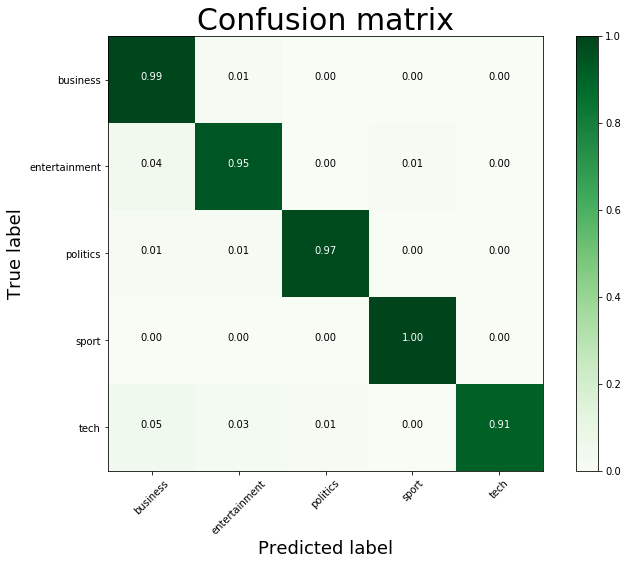

In [86]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix",cmap="Greens")
plt.show()

## Glove Embeddings

In [11]:
TEXT_DATA_DIR = 'E:\\param.ai\\task\\bbc\\'
#the path for Glove embeddings
GLOVE_DIR = 'E:\\MI-AI-Challenge'
# make the max word length to be constant
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 2

In [12]:
texts = df['news']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(df['type'])

In [15]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 32360
Shape of data tensor: (2225, 1000)
Shape of label tensor: (2225, 5)
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


In [16]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [17]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [19]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [86]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('glove_saved_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

(?, 1000, 100)
(?, 1000, 100, 1)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    3236100     input_8[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 1000, 100, 1) 0           embedding_1[7][0]                
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 998, 1, 512)  154112      reshape_8[0][0]                  
___________________________________________________________

#### Model Graph

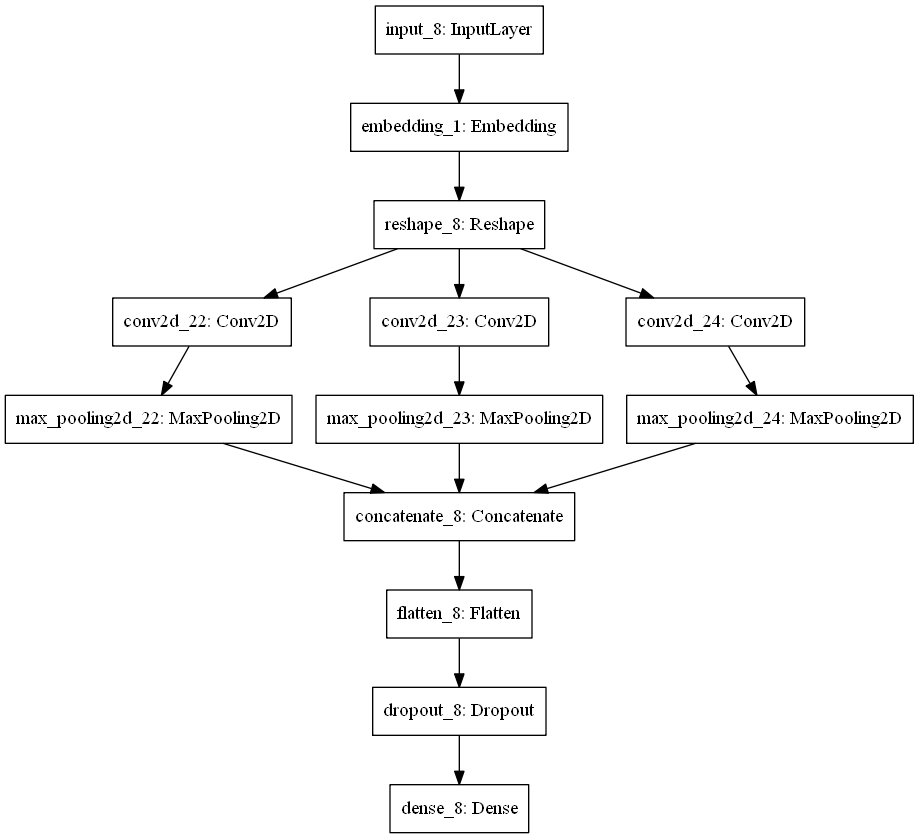

In [87]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [88]:
print("Traning Model...")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Train on 1780 samples, validate on 445 samples
Epoch 1/20
1780/1780 [==============================] - 124s 70ms/step - loss: 0.7138 - acc: 0.7352 - val_loss: 0.3253 - val_acc: 0.8521

Epoch 00001: val_loss improved from inf to 0.32532, saving model to glove_saved_model.hdf5
Epoch 2/20
1780/1780 [==============================] - 115s 65ms/step - loss: 0.4861 - acc: 0.8013 - val_loss: 0.2075 - val_acc: 0.9290

Epoch 00002: val_loss improved from 0.32532 to 0.20748, saving model to glove_saved_model.hdf5
Epoch 3/20
1780/1780 [==============================] - 112s 63ms/step - loss: 0.3564 - acc: 0.8516 - val_loss: 0.1360 - val_acc: 0.9712

Epoch 00003: val_loss improved from 0.20748 to 0.13605, saving model to glove_saved_model.hdf5
Epoch 4/20
1780/1780 [==============================] - 117s 66ms/step - loss: 0.2697 - acc: 0.8902 - val_loss: 0.1031 - val_acc: 0.9753

Epoch 00004: val_loss improved from 0.13605 to 0.10311, saving model to glove_saved_model.hdf5
Epoch 5/

### Learning Curves

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


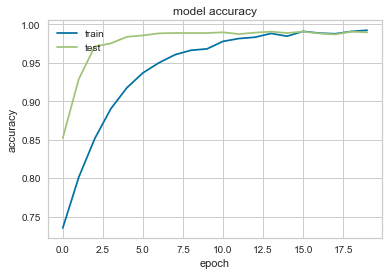

In [89]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

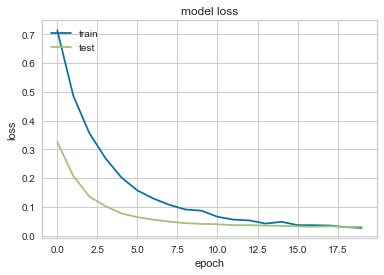

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Bert Model

### BERT Requirements

In [ ]:
#!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip --no-check-certificate
#!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py --no-check-certificate
#!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py --no-check-certificate
#!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py --no-check-certificate
#!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py --no-check-certificate

### Setting BERT Configurations

In [2]:
cd bert_model

E:\param.ai\task\bert_model


In [17]:
import modeling
import optimization
import run_classifier
import tokenization

In [18]:
import zipfile

folder = 'model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs
>>  BERT pretrained directory: model_folder/uncased_L-12_H-768_A-12


In [30]:
from sklearn.model_selection import train_test_split
import tensorflow as tf4
import datetime

In [31]:
df2 = pd.DataFrame()
df2["Text"] = df["news"]
df2["Label"] = LabelEncoder().fit_transform(df['type'])
#df2 = df2[:200000]
df2.head()

,Text,Label
0,Franz Ferdinand's art school lesson\n \n Scott...,1
1,Hewitt falls to Dent in Adelaide\n \n Lleyton ...,3
2,Bafta to hand out movie honours\n \n Movie sta...,1
3,Robinson ready for difficult task\n \n England...,3
4,'Hitler' row over Welsh arts cash\n \n An arti...,2


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df2["Text"].values, df2["Label"].values, test_size=0.2, random_state=42)
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 50
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

label_list = [str(num) for num in range(8)]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

INFO:tensorflow:Using config: {'_model_dir': 'model_folder/outputs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020A229B2CF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=100000, num_shards=8, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep_s

### Train BERT Model

In [33]:
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

Please wait...
INFO:tensorflow:Writing example 0 of 1780
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:tensorflow:tokens: [CLS] rap feud in 50 cent ' s g - unit crew us rap star 50 cent has said he has thrown protege the game out of his g - unit gang in a feud that has apparently involved two shooting ##s . in a radio interview on monday [SEP]
INFO:tensorflow:input_ids: 101 9680 13552 1999 2753 9358 1005 1055 1043 1011 3131 3626 2149 9680 2732 2753 9358 2038 2056 2002 2038 6908 28567 1996 2208 2041 1997 2010 1043 1011 3131 6080 1999 1037 13552 2008 2038 4593 2920 2048 5008 2015 1012 1999 1037 2557 4357 2006 6928 102
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 1 (id = 1)
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:t

INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKP

INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/

INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:

In [34]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 500

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

INFO:tensorflow:Writing example 0 of 445
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] italy aim to rattle england italy coach john ki ##r ##wan believes his side can upset england as the six nations wooden spoon battle hot ##s up . the two sides , both without a win , meet on 12 march at t ##wick ##enham and ki ##r [SEP]
INFO:tensorflow:input_ids: 101 3304 6614 2000 23114 2563 3304 2873 2198 11382 2099 7447 7164 2010 2217 2064 6314 2563 2004 1996 2416 3741 4799 15642 2645 2980 2015 2039 1012 1996 2048 3903 1010 2119 2302 1037 2663 1010 3113 2006 2260 2233 2012 1056 7184 23580 1998 11382 2099 102
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 0 (id = 0)
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INF

In [35]:
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 50)
INFO:tensorflow:  name = input_mask, shape = (?, 50)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 50)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/l

INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,), *INIT_FROM_CKP

INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorfl

### Model Performance Check

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.9820224719101124


In [39]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           1       1.00      0.97      0.98        89
           2       1.00      0.98      0.99        85
           3       0.99      0.99      0.99        93
           4       0.95      0.99      0.97        76

   micro avg       0.98      0.98      0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445

